In [1]:
# Efficient math and data management
import numpy as np
import pandas as pd 

# Useful for machine learning
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.svm import SVC
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, precision_recall_fscore_support, classification_report, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import sklearn.metrics as sm

# Visualization
import matplotlib
import matplotlib.pyplot as plt

# Other useful libraries
import os
from functools import reduce 
import scipy.stats as stats

%matplotlib inline

## Loading Data

In [2]:
data_directory = '/Users/jonasmatos/Documents/Spring 2021/CS 590W/Final Project/data'

# Using a dictionary and loop to automatically load all files, but a hard-coded series of data loading statements is also acceptable.
data = {}
for filename in os.listdir(data_directory):
    file = os.path.abspath(os.path.join(data_directory, filename))
    name, ext = os.path.splitext(os.path.basename(file))
    if ext.lower() == '.xpt':
        data[name[:-2]] = pd.read_sas(file, encoding='UTF-8')  

print('Loaded files: {}'.format(', '.join(data.keys())))

Loaded files: SLQ, DPQ, BMX, PAQ, DUQ, DIQ, ALQ, SMQ, WHQ, OCQ


In [3]:
data['DIQ'][:10]

,SEQN,DIQ010,DID040,DIQ160,DIQ170,DIQ172,DIQ175A,DIQ175B,DIQ175C,DIQ175D,...,DIQ300D,DID310S,DID310D,DID320,DID330,DID341,DID350,DIQ350U,DIQ360,DIQ080
0,93703.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,93704.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,93705.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,93706.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,93707.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,93708.0,3.0,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,93709.0,2.0,NaN,1.0,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,93711.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,93712.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,93713.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def join_files(a, b):  # Could make a one-liner using a lambda, but this is more readable
    return a.merge(b, on='SEQN', how='outer')

# Merge all files into one large dataset
total_data = reduce(join_files, [data[i] for i in data])

# Data that includes the features needed for the analysis
model_data = total_data.filter(['SEQN','ALQ130','DUQ230','DIQ010','PAQ610','BMXBMI','SMD650','OCQ180','SLD012'])

In [5]:
total_data[:10]

,SEQN,SLQ300,SLQ310,SLD012,SLQ320,SLQ330,SLD013,SLQ030,SLQ040,SLQ050,...,WHQ200,OCD150,OCQ180,OCQ210,OCQ260,OCD270,OCQ670,OCQ380,OCD390G,OCD395
0,93705.0,23:00,07:00,8.0,23:00,07:00,8.0,2.000000e+00,5.397605e-79,2.0,...,NaN,1.0,30.0,1.0,1.0,36.0,5.0,NaN,2.0,NaN
1,93706.0,23:30,10:00,10.5,00:30,12:00,11.5,1.000000e+00,5.397605e-79,2.0,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN
2,93708.0,22:30,06:30,8.0,22:30,06:30,8.0,9.000000e+00,5.397605e-79,2.0,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,1.0,180.0
3,93709.0,22:30,05:30,7.0,22:30,05:00,6.5,1.000000e+00,5.397605e-79,2.0,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,6.0,1.0,360.0
4,93711.0,22:00,05:00,7.0,23:00,08:00,9.0,2.000000e+00,1.000000e+00,1.0,...,NaN,1.0,35.0,NaN,4.0,24.0,1.0,NaN,2.0,NaN
5,93712.0,23:30,07:00,7.5,01:00,10:00,9.0,1.000000e+00,1.000000e+00,2.0,...,NaN,1.0,55.0,NaN,1.0,2.0,1.0,NaN,2.0,NaN
6,93713.0,22:30,04:00,5.5,23:00,06:00,7.0,5.397605e-79,5.397605e-79,1.0,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,3.0,1.0,300.0
7,93714.0,23:00,06:00,7.0,00:00,08:00,8.0,3.000000e+00,5.397605e-79,1.0,...,NaN,2.0,NaN,1.0,1.0,264.0,3.0,NaN,2.0,NaN
8,93715.0,01:00,06:00,5.0,01:00,06:00,5.0,3.000000e+00,5.397605e-79,1.0,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,3.0,1.0,120.0
9,93716.0,22:00,05:00,7.0,23:00,08:00,9.0,3.000000e+00,5.397605e-79,1.0,...,NaN,1.0,40.0,NaN,4.0,336.0,1.0,NaN,2.0,NaN


In [6]:
# Returning responses from depression screening questions that yield a code within the desired 0-3 range

depression_data = total_data.filter(['SEQN','DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090'])
depression_data.round() # Converts the depression values displayed in scientific notation into floats
depression_data['DPQ010'].unique() # Included responses greater than 3, which we do not want for the analysis. 

# Filtered the responses that fall within the 0-3 range in order to accurately calculate the PHQ-9 scores later on 
depress_filt = np.where((depression_data['DPQ010'] < 4) & (depression_data['DPQ020'] < 4) & (depression_data['DPQ030'] < 4) 
               & (depression_data['DPQ040'] < 4) & (depression_data['DPQ050'] < 4) & (depression_data['DPQ060'] < 4)
               & (depression_data['DPQ070'] < 4) & (depression_data['DPQ080'] < 4) & (depression_data['DPQ090'] < 4))

depression_data = depression_data.loc[depress_filt]
depression_data.dropna(how='any')

# Verifying that each column contains responses within the 0-3 range
for column in depression_data.columns:
    print(depression_data[column].unique().round())

[ 93705.  93706.  93708. ... 102953. 102954. 102956.]
[0. 1. 3. 2.]
[0. 1. 3. 2.]
[0. 1. 2. 3.]
[0. 1. 3. 2.]
[0. 1. 3. 2.]
[0. 1. 2. 3.]
[0. 2. 1. 3.]
[0. 1. 3. 2.]
[0. 1. 2. 3.]


In [7]:
# Set all NaN's to zeros so it does not affect the calculation of the PHQ-9 score
depression_data['DPQ010'].fillna(0, inplace=True)
depression_data['DPQ020'].fillna(0, inplace=True)
depression_data['DPQ030'].fillna(0, inplace=True)
depression_data['DPQ040'].fillna(0, inplace=True)
depression_data['DPQ050'].fillna(0, inplace=True)
depression_data['DPQ060'].fillna(0, inplace=True)
depression_data['DPQ070'].fillna(0, inplace=True)
depression_data['DPQ080'].fillna(0, inplace=True)
depression_data['DPQ090'].fillna(0, inplace=True)

In [8]:
model_data = join_files(model_data, depression_data)

# Uncomment next line to see improvement in the model's performance when conditioning on subjects with sleep deprivation!
#model_data = model_data[(model_data['SLD012'] < 7) & (model_data['OCQ180'] > 40)] # Restricting to subjects who work over 40 hours per week and sleep less than 7 hours per day

model_data['DUQ230'].fillna(0, inplace=True)
model_data

,SEQN,ALQ130,DUQ230,DIQ010,PAQ610,BMXBMI,SMD650,OCQ180,SLD012,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090
0,93705.0,1.0,0.0,2.0,NaN,31.7,NaN,30.0,8.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
1,93706.0,NaN,0.0,2.0,NaN,21.5,NaN,NaN,10.5,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
2,93708.0,NaN,0.0,3.0,NaN,23.7,NaN,NaN,8.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
3,93709.0,NaN,0.0,2.0,NaN,38.9,5.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,93711.0,1.0,0.0,2.0,NaN,21.3,NaN,35.0,7.0,1.000000e+00,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9230,102742.0,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9231,102874.0,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9232,102888.0,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9233,102902.0,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
model_data['ALQ130'] = model_data['ALQ130'].fillna(0) # Consider subjects that have consumed 0 drinks

# Remove subjects who either refused to answer the questions or answered "don't know"
no_alcohol = model_data[(model_data['ALQ130'] == 777) | (model_data['ALQ130'] == 999)].index
model_data.drop(no_alcohol, inplace=True)

no_physical = model_data[(model_data['PAQ610'] == 77) | (model_data['PAQ610'] == 99)].index
model_data.drop(no_physical, inplace=True)

no_smoking = model_data[(model_data['SMD650'] == 777) | (model_data['SMD650'] == 999)].index
model_data.drop(no_smoking, inplace=True)

no_occupation = model_data[(model_data['OCQ180'] == 77777) | (model_data['OCQ180'] == 99999)].index
model_data.drop(no_occupation, inplace=True)

no_diabetes = model_data[(model_data['DIQ010'] == 7) | (model_data['DIQ010'] == 9)].index
model_data.drop(no_diabetes, inplace=True)

model_data

,SEQN,ALQ130,DUQ230,DIQ010,PAQ610,BMXBMI,SMD650,OCQ180,SLD012,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090
0,93705.0,1.0,0.0,2.0,NaN,31.7,NaN,30.0,8.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
1,93706.0,0.0,0.0,2.0,NaN,21.5,NaN,NaN,10.5,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
2,93708.0,0.0,0.0,3.0,NaN,23.7,NaN,NaN,8.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
3,93709.0,0.0,0.0,2.0,NaN,38.9,5.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,93711.0,1.0,0.0,2.0,NaN,21.3,NaN,35.0,7.0,1.000000e+00,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9230,102742.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9231,102874.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9232,102888.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9233,102902.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Excluded 'DPQ100' since it is not included in the calculation of the PHQ-9 score (defined in the reference papers)
depression_questions = ['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090']

# Calculation of PHQ-9 score for each subject
model_data["Depression"] = model_data.loc[:, depression_questions].sum(axis=1).astype('int64') 

# Drops all rows that include NaN's
model_data = model_data.dropna(how='any')

model_data

,SEQN,ALQ130,DUQ230,DIQ010,PAQ610,BMXBMI,SMD650,OCQ180,SLD012,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,Depression
5,93712.0,0.0,1.0,2.0,6.0,19.7,2.0,55.0,7.5,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1
26,93743.0,0.0,0.0,2.0,7.0,22.5,20.0,53.0,5.5,5.397605e-79,5.397605e-79,1.000000e+00,3.000000e+00,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5
37,93761.0,2.0,0.0,2.0,5.0,29.0,10.0,40.0,8.0,5.397605e-79,3.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,3
185,93972.0,5.0,0.0,2.0,5.0,29.6,10.0,55.0,6.5,5.397605e-79,5.397605e-79,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,1
197,93987.0,7.0,0.0,2.0,5.0,39.2,8.0,32.0,6.5,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6117,102884.0,4.0,0.0,2.0,5.0,31.7,2.0,60.0,9.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,0
6139,102918.0,6.0,0.0,2.0,5.0,22.4,10.0,40.0,9.0,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,0
6142,102922.0,3.0,0.0,2.0,6.0,20.8,11.0,55.0,3.5,5.397605e-79,1.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,1.000000e+00,1.000000e+00,5.397605e-79,5.397605e-79,3
6147,102934.0,3.0,0.0,2.0,5.0,26.3,12.0,40.0,7.5,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,2.000000e+00,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,2


In [11]:
model_data['Depression'].value_counts(normalize=True)*100 # useful distribution of the PHQ-9 scores

0     27.619048
1     12.857143
2     12.380952
3      8.571429
8      7.142857
4      5.714286
5      5.238095
6      5.238095
7      3.333333
10     2.857143
9      1.904762
14     1.428571
15     1.428571
11     0.952381
12     0.952381
17     0.952381
19     0.476190
16     0.476190
22     0.476190
Name: Depression, dtype: float64

In [12]:
# Remove depression screening questions from dataframe as features
model_data = model_data.drop(['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090'], axis=1)

model_data 

,SEQN,ALQ130,DUQ230,DIQ010,PAQ610,BMXBMI,SMD650,OCQ180,SLD012,Depression
5,93712.0,0.0,1.0,2.0,6.0,19.7,2.0,55.0,7.5,1
26,93743.0,0.0,0.0,2.0,7.0,22.5,20.0,53.0,5.5,5
37,93761.0,2.0,0.0,2.0,5.0,29.0,10.0,40.0,8.0,3
185,93972.0,5.0,0.0,2.0,5.0,29.6,10.0,55.0,6.5,1
197,93987.0,7.0,0.0,2.0,5.0,39.2,8.0,32.0,6.5,0
...,...,...,...,...,...,...,...,...,...,...
6117,102884.0,4.0,0.0,2.0,5.0,31.7,2.0,60.0,9.0,0
6139,102918.0,6.0,0.0,2.0,5.0,22.4,10.0,40.0,9.0,0
6142,102922.0,3.0,0.0,2.0,6.0,20.8,11.0,55.0,3.5,3
6147,102934.0,3.0,0.0,2.0,5.0,26.3,12.0,40.0,7.5,2


In [13]:
# Verifying that total PHQ-9 scores range from 0-27
model_data['Depression'].unique()

array([ 1,  5,  3,  0,  2, 11,  6, 10, 16,  8, 12, 14,  4, 15,  7,  9, 22,
       17, 19])

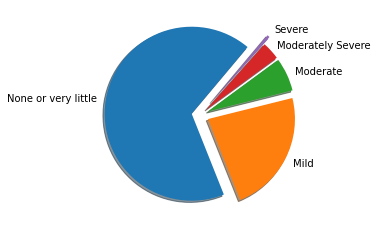

In [14]:
# Categorization of severity of depression
score_lst = []
for subject in model_data['Depression']:
    if subject < 5:
        score_lst.append("None or very little")
    elif subject >= 5 and subject < 10:
        score_lst.append("Mild")
    elif subject >= 10 and subject < 15:
        score_lst.append("Moderate")
    elif subject >= 15 and subject < 20:
        score_lst.append("Moderately Severe")
    else:
        score_lst.append("Severe")
        
none_count = score_lst.count("None or very little")
mild_count = score_lst.count("Mild")
moderate_count = score_lst.count("Moderate")
moderately_count = score_lst.count("Moderately Severe")
severe_count = score_lst.count("Severe")

depress_scores = []
depress_scores.append(none_count)
depress_scores.append(mild_count)
depress_scores.append(moderate_count)
depress_scores.append(moderately_count)
depress_scores.append(severe_count)

depress_scores = np.array(depress_scores)
depress_labels = ["None or very little","Mild","Moderate","Moderately Severe", "Severe"] 
explodes = [0.1,0.1,0.1,0.1,0.2]

plt.pie(depress_scores, labels=depress_labels, startangle=50, explode=explodes, shadow=True)
#plt.legend()
plt.show()

In [15]:
print("Percentage Distribution of subjects with depression based on PHQ-9 scores")

print()

print("{:.2f}% of all subjects have no or very little depression".format(none_count/len(score_lst)*100))
print("{:.2f}% of all subjects have mild depression".format(mild_count/len(score_lst)*100))
print("{:.2f}% of all subjects have moderate depression".format(moderate_count/len(score_lst)*100))
print("{:.2f}% of all subjects have moderately severe depression".format(moderately_count/len(score_lst)*100))
print("{:.2f}% of all subjects have severe depression".format(severe_count/len(score_lst)*100))

Percentage Distribution of subjects with depression based on PHQ-9 scores

67.14% of all subjects have no or very little depression
22.86% of all subjects have mild depression
6.19% of all subjects have moderate depression
3.33% of all subjects have moderately severe depression
0.48% of all subjects have severe depression


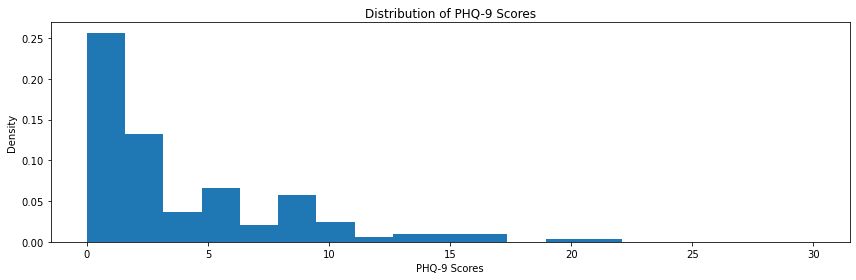

In [16]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(model_data['Depression'], bins=np.linspace(0, 30, 20), density=True)
ax.set_xlabel('PHQ-9 Scores')
ax.set_ylabel('Density')
ax.set_title("Distribution of PHQ-9 Scores")
#ax.set_yticks(np.linspace(0, .1, 4))
fig.tight_layout()

In [17]:
def map_score(score):
    if score < 5:
        return "None or very little"
    elif score >= 5 and score < 10:
        return "Mild"
    elif score >= 10 and score < 15:
        return "Moderate"
    elif score >= 15 and score < 20:
        return "Moderately Severe"
    else:
        return "Severe"

class_labels = np.array(model_data["Depression"].apply(lambda score: map_score(score)))

#class_labels  # Uncomment this line to see the class labels corresponding to their respective PHQ-9 depression scores

In [18]:
#model_data = model_data.drop(['DUQ230'], axis=1) # Drop least correlated variable

model_data

,SEQN,ALQ130,DUQ230,DIQ010,PAQ610,BMXBMI,SMD650,OCQ180,SLD012,Depression
5,93712.0,0.0,1.0,2.0,6.0,19.7,2.0,55.0,7.5,1
26,93743.0,0.0,0.0,2.0,7.0,22.5,20.0,53.0,5.5,5
37,93761.0,2.0,0.0,2.0,5.0,29.0,10.0,40.0,8.0,3
185,93972.0,5.0,0.0,2.0,5.0,29.6,10.0,55.0,6.5,1
197,93987.0,7.0,0.0,2.0,5.0,39.2,8.0,32.0,6.5,0
...,...,...,...,...,...,...,...,...,...,...
6117,102884.0,4.0,0.0,2.0,5.0,31.7,2.0,60.0,9.0,0
6139,102918.0,6.0,0.0,2.0,5.0,22.4,10.0,40.0,9.0,0
6142,102922.0,3.0,0.0,2.0,6.0,20.8,11.0,55.0,3.5,3
6147,102934.0,3.0,0.0,2.0,5.0,26.3,12.0,40.0,7.5,2


In [19]:
model_data.interpolate(method='linear')

,SEQN,ALQ130,DUQ230,DIQ010,PAQ610,BMXBMI,SMD650,OCQ180,SLD012,Depression
5,93712.0,0.0,1.0,2.0,6.0,19.7,2.0,55.0,7.5,1
26,93743.0,0.0,0.0,2.0,7.0,22.5,20.0,53.0,5.5,5
37,93761.0,2.0,0.0,2.0,5.0,29.0,10.0,40.0,8.0,3
185,93972.0,5.0,0.0,2.0,5.0,29.6,10.0,55.0,6.5,1
197,93987.0,7.0,0.0,2.0,5.0,39.2,8.0,32.0,6.5,0
...,...,...,...,...,...,...,...,...,...,...
6117,102884.0,4.0,0.0,2.0,5.0,31.7,2.0,60.0,9.0,0
6139,102918.0,6.0,0.0,2.0,5.0,22.4,10.0,40.0,9.0,0
6142,102922.0,3.0,0.0,2.0,6.0,20.8,11.0,55.0,3.5,3
6147,102934.0,3.0,0.0,2.0,5.0,26.3,12.0,40.0,7.5,2


Determine features and class label (target variable)

In [34]:
features = model_data.iloc[:, 1:9].to_numpy() # features included in order to predict depression score
target_var = model_data.iloc[:, -1].to_numpy() # class target label for depression

feature_names = model_data.columns[1:9]
model_data
feature_names

Index(['ALQ130', 'DUQ230', 'DIQ010', 'PAQ610', 'BMXBMI', 'SMD650', 'OCQ180',
       'SLD012'],
      dtype='object')

Splitting data into training and test set

In [35]:
np.random.seed(0)

X_train, X_test, y_train, y_test = train_test_split(features, target_var, test_size=0.30)

Normalize features to have zero mean & unit variance

In [36]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Creation of Gaussian Process Regression Model

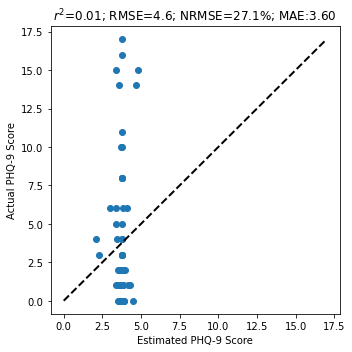

In [37]:
kernel = 1 * RBF() + ConstantKernel()  # Need to choose a kernel for GPR, this is a decent choice

model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, optimizer='fmin_l_bfgs_b', normalize_y=True, alpha=0).fit(X_train, y_train)
y_hat = model.predict(X_test)

# Useful metrics for regression model
r2_val = r2_score(y_test, y_hat)
rmse = np.sqrt(np.mean(np.square(y_test - y_hat)))
nrmse = rmse / np.ptp(y_test)
mae = round(sm.mean_absolute_error(y_test, y_hat), 1)


# Plot of the model's performance along with the useful metrics (R^2 score, RMSE, & NRMSE)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_hat, y_test)
min_, max_ = min(y_hat.min(), y_test.min()), max(y_hat.max(), y_test.max())
x = np.linspace(min_, max_, 100)  # Perfect estimation line
ax.plot(x, x, linestyle='--', color='k', linewidth=2)
ax.set_xlabel('Estimated PHQ-9 Score')
ax.set_ylabel('Actual PHQ-9 Score')
ax.set_title('$r^2$={:.2f}; RMSE={:.1f}; NRMSE={:.1f}%; MAE:{:.2f}'.format(r2_val, rmse, nrmse * 100, mae))
fig.tight_layout()

In [24]:
# Other useful regression metrics
print("Mean Absolute Error = {}".format(round(sm.mean_absolute_error(y_test, y_hat), 1)))
print("Explained Variance Score = {}".format(round(sm.explained_variance_score(y_test, y_hat), 3)))

Mean Absolute Error = 3.6
Explained Variance Score = 0.013


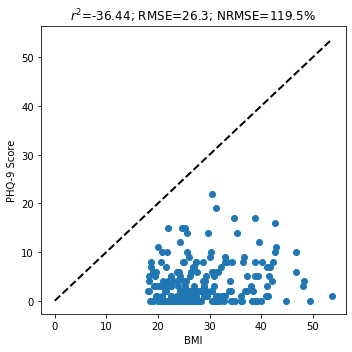

In [25]:
# Relationship between a subject's bmi and the PHQ-9 score

bmi = model_data['BMXBMI']
depression = model_data['Depression']

r2_val1 = r2_score(depression, bmi)
rmse1 = np.sqrt(np.mean(np.square(depression - bmi)))
nrmse1 = rmse1 / np.ptp(depression)


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(bmi, depression)
min_, max_ = min(bmi.min(), depression.min()), max(bmi.max(), depression.max())
x = np.linspace(min_, max_, 100)  # Perfect estimation line
ax.plot(x, x, linestyle='--', color='k', linewidth=2)
ax.set_xlabel('BMI')
ax.set_ylabel('PHQ-9 Score')
ax.set_title('$r^2$={:.2f}; RMSE={:.1f}; NRMSE={:.1f}%'.format(r2_val1, rmse1, nrmse1 * 100))
fig.tight_layout()

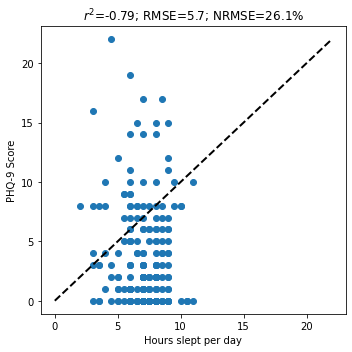

In [26]:
# Relationship between hours slept per day and the PHQ-9 score

sleep = model_data['SLD012']
depression = model_data['Depression']

r2_val2 = r2_score(depression, sleep)
rmse2 = np.sqrt(np.mean(np.square(depression - sleep)))
nrmse2 = rmse2 / np.ptp(depression)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sleep, depression)
min_, max_ = min(sleep.min(), depression.min()), max(sleep.max(), depression.max())
x = np.linspace(min_, max_, 100)  # Perfect estimation line
ax.plot(x, x, linestyle='--', color='k', linewidth=2)
ax.set_xlabel('Hours slept per day')
ax.set_ylabel('PHQ-9 Score')
ax.set_title('$r^2$={:.2f}; RMSE={:.1f}; NRMSE={:.1f}%'.format(r2_val2, rmse2, nrmse2 * 100))
fig.tight_layout()

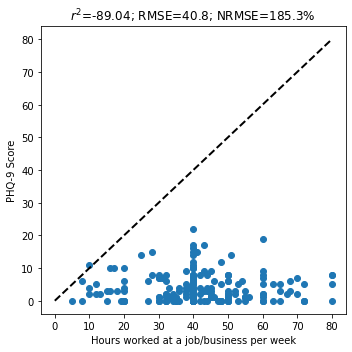

In [27]:
# Relationship between the hours worked at a job/business per week and the PHQ-9 score

occupation = model_data['OCQ180']
depression = model_data['Depression']

r2_val3 = r2_score(depression, occupation)
rmse3 = np.sqrt(np.mean(np.square(depression - occupation)))
nrmse3 = rmse3 / np.ptp(depression)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(occupation, depression)
min_, max_ = min(occupation.min(), depression.min()), max(occupation.max(), depression.max())
x = np.linspace(min_, max_, 100)  # Perfect estimation line
ax.plot(x, x, linestyle='--', color='k', linewidth=2)
ax.set_xlabel('Hours worked at a job/business per week')
ax.set_ylabel('PHQ-9 Score')
ax.set_title('$r^2$={:.2f}; RMSE={:.1f}; NRMSE={:.1f}%'.format(r2_val3, rmse3, nrmse3 * 100))
fig.tight_layout()

In [28]:
diabetes = model_data['DIQ010']
depression = model_data['Depression']

In [29]:
print("Correlation between bmi and depression (PHQ-9 score):")
print('r={:.2f}, p={:.2e}'.format(*stats.pearsonr(bmi, depression)))
print()

print("Correlation between sleep and depression (PHQ-9 score):")
print('r={:.2f}, p={:.2e}'.format(*stats.pearsonr(sleep, depression)))
print()

print("Correlation between occupation and depression (PHQ-9 score):")
print('r={:.2f}, p={:.2e}'.format(*stats.pearsonr(occupation, depression)))
print()

print("Correlation between diabetes and depression (PHQ-9 score):")
print('r={:.2f}, p={:.2e}'.format(*stats.pearsonr(diabetes, depression)))
print()

Correlation between bmi and depression (PHQ-9 score):
r=0.14, p=3.91e-02

Correlation between sleep and depression (PHQ-9 score):
r=-0.09, p=2.09e-01

Correlation between occupation and depression (PHQ-9 score):
r=-0.01, p=8.56e-01

Correlation between diabetes and depression (PHQ-9 score):
r=0.01, p=9.06e-01



Gaussian Process Regression Model including the four most "imporant" features

In [30]:
model_data = model_data.drop(['PAQ610','DUQ230','ALQ130'],axis=1)
model_data

,SEQN,ALQ130,DUQ230,DIQ010,PAQ610,BMXBMI,SMD650,OCQ180,SLD012,Depression
5,93712.0,0.0,1.0,2.0,6.0,19.7,2.0,55.0,7.5,1
26,93743.0,0.0,0.0,2.0,7.0,22.5,20.0,53.0,5.5,5
37,93761.0,2.0,0.0,2.0,5.0,29.0,10.0,40.0,8.0,3
185,93972.0,5.0,0.0,2.0,5.0,29.6,10.0,55.0,6.5,1
197,93987.0,7.0,0.0,2.0,5.0,39.2,8.0,32.0,6.5,0
...,...,...,...,...,...,...,...,...,...,...
6117,102884.0,4.0,0.0,2.0,5.0,31.7,2.0,60.0,9.0,0
6139,102918.0,6.0,0.0,2.0,5.0,22.4,10.0,40.0,9.0,0
6142,102922.0,3.0,0.0,2.0,6.0,20.8,11.0,55.0,3.5,3
6147,102934.0,3.0,0.0,2.0,5.0,26.3,12.0,40.0,7.5,2


In [31]:
features = model_data.iloc[:, :-1].to_numpy() # features included in order to predict depression score
target_var = model_data.iloc[:, -1].to_numpy()

np.random.seed(0)

X_train, X_test, y_train, y_test = train_test_split(features, target_var, test_size=0.30)

In [32]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

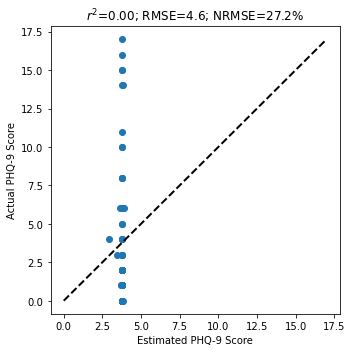

In [33]:
kernel = 1 * RBF() + WhiteKernel()  # Need to choose a kernel for GPR, this is a decent choice

model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, optimizer='fmin_l_bfgs_b', normalize_y=True, alpha=0).fit(X_train, y_train)
y_hat = model.predict(X_test)

# Useful metrics for regression model
r2_val = r2_score(y_test, y_hat)
rmse = np.sqrt(np.mean(np.square(y_test - y_hat)))
nrmse = rmse / np.ptp(y_test)


# Plot of the model's performance along with the useful metrics (R^2 score, RMSE, & NRMSE)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_hat, y_test)
min_, max_ = min(y_hat.min(), y_test.min()), max(y_hat.max(), y_test.max())
x = np.linspace(min_, max_, 100)  # Perfect estimation line
ax.plot(x, x, linestyle='--', color='k', linewidth=2)
ax.set_xlabel('Estimated PHQ-9 Score')
ax.set_ylabel('Actual PHQ-9 Score')
ax.set_title('$r^2$={:.2f}; RMSE={:.1f}; NRMSE={:.1f}%'.format(r2_val, rmse, nrmse * 100))
fig.tight_layout()